In [81]:
from pathlib import Path
import numpy as np
import pypolo2

# Environment

We will download the image of 30-meter resolution elevation data from the [Shuttle Radar Topography Mission](https://www2.jpl.nasa.gov/srtm/) and use the elevation map as the ground-truth environment.
You can preview the image and choose your favorate tile from the link below.
Note down the tile ID, e.g., N17E073.
PyPolo provides utility function to download and preprocess the data.

https://dwtkns.com/srtm30m/

In [82]:
Setting = pypolo2.utilities.Config()
initial_field_test = 10 * np.ones((Setting.grid_x, Setting.grid_y))


model_test = pypolo2.experiments.environments.Diffusion_Model(Setting) # build model
Setting.env = model_test.solve(3)

100%|██████████| 3.0/3.0 [00:00<00:00,  5.76it/s]    


In [83]:
import pandas as pd
import os
dir = "./data/MyProData/Total1123.csv"

#读取数据
df_env = pd.read_csv(dir)
df_env_timeindex = df_env.set_index('time')

In [86]:
base_time = pd.Timestamp('2018-11-23 00:00:00')

# 选择时间段
start_time = pd.Timestamp('2018-11-23 06:00:00')
end_time = pd.Timestamp('2018-11-23 23:00:00')

#计算时间点
df_env['time_int'] = df_env['time'].apply(lambda x: round((pd.Timestamp(x) - base_time).total_seconds() / 60 / 10))

# 将 time 字段转换为 Pandas 中的 Timestamp 类型
df_env['time'] = pd.to_datetime(df_env['time'], format="%Y-%m-%d %H:%M:%S")

# 从 DataFrame 中选择符合时间段的数据
mask = (df_env['time'] >= start_time) & (df_env['time'] <= end_time)
selected_data = df_env.loc[mask]

data_x_env = selected_data.loc[:, ['lat_bin', 'lon_bin', 'time_int', 'time']].values
data_y_env = selected_data.loc[:, ['pm2d5', 'time_int', 'time']].values

data_x = data_x_env[:,0:3]
data_y = data_y_env[:,0]

data_x[:,2] = data_x[:,2]*Setting.time_co

In [101]:
time_start = data_x[:,2].min(axis=0, keepdims=False)
time_end = data_x[:,2].max(axis=0, keepdims=False)

We specify the environment extent and task extent. The robot can move within the environment extent but we only conduct the Robotic Information Gathering task in the task extent. We need to leave some buffer space because the robot is not guaranteed to always stay in the workspace due to [underactuation](https://en.wikipedia.org/wiki/Underactuation) or external disturbances. For example, an Autonomous Surface Vehicle (ASV) cannot turn in-place while moving at a high speed due to inertia and its motion can be disturbed by waves or strong wind.

# Sensor

In [87]:
sensor = pypolo2.sensors.Sprinkler(
    Setting = Setting
)

# Pilot Survey

In [88]:
rng = pypolo2.experiments.utilities.seed_everything(Setting = Setting)

Set random seed to 0 in random, numpy, and torch.


# Model

In [89]:
Setting.time_stamp = data_x[:,2].max(axis=0, keepdims=False)

In [90]:
kernel = pypolo2.kernels.RBF(Setting)

In [91]:
model = pypolo2.models.GPR(
    x_train=data_x.astype(np.float64),
    y_train=data_y.reshape(-1,1).astype(np.float64),
    kernel=kernel,
    noise=Setting.init_noise,
    lr_hyper=Setting.lr_hyper,
    lr_nn=Setting.lr_nn,
    is_normalized = True,
    time_stamp = Setting.time_stamp,
)

In [92]:
model.optimize(num_iter=model.num_train, verbose=True)

Iter: 3040 loss:  3072.71: 100%|██████████| 3041/3041 [1:17:50<00:00,  1.54s/it]


In [102]:
for time in range(int((time_end-time_start)/Setting.time_co)+1):
    allstate_list = []
    for i in range (Setting.task_extent[0],Setting.task_extent[1]+1):
        for j in range (Setting.task_extent[2],Setting.task_extent[3]+1):
            allstate_list.append([i, j, time_start+time*Setting.time_co])
    allstate = np.array(allstate_list)
    #compute predict mean and sprink_effect of all point
    mean, _ = model(allstate)
    pred = np.zeros((Setting.task_extent[1]+1-Setting.task_extent[0],Setting.task_extent[3]+1-Setting.task_extent[2]))
    for i in range (Setting.task_extent[0],Setting.task_extent[1]+1):
        for j in range (Setting.task_extent[2],Setting.task_extent[3]+1):
            pred[i,j] = mean[i*(Setting.task_extent[3]+1-Setting.task_extent[2])+j,0]
    Setting.env_list.append(pred.copy())

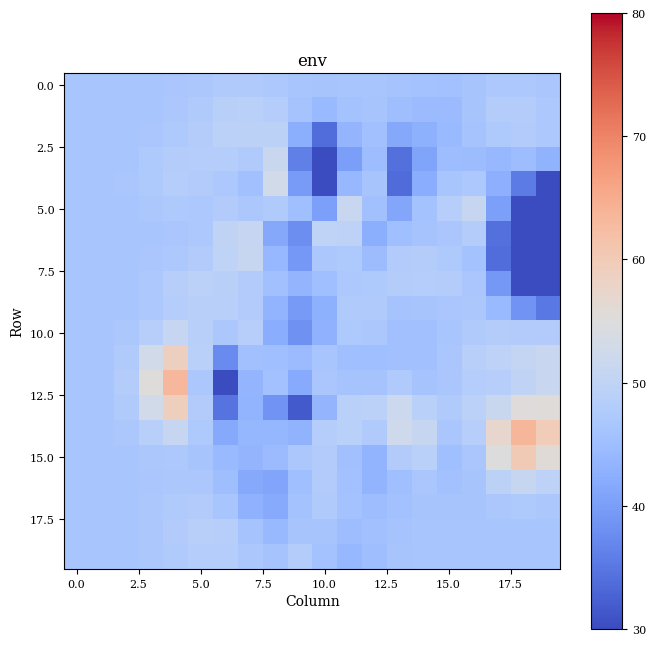

In [105]:
from matplotlib import pyplot as plt
import matplotlib.animation
import matplotlib.cm as cm
import matplotlib.colors as colors
from matplotlib import ticker as ticker
from pypolo2.experiments import visualizer
# Create two subplots for env_list and mi_list heatmaps
fig, ax = plt.subplots(1, 1, figsize=(8, 8))

ax.set_title('env')
ax.set_xlabel('Column')
ax.set_ylabel('Row')

# Set axis limits for both subplots
ax.axis([-0.5, 19.5, -0.5, 19.5])


# Invert y-axis for both subplots
ax.invert_yaxis()

# Create heatmap objects for both subplots
heatmap3 = Setting.env_list[0]

im3 = ax.imshow(heatmap3, cmap=cm.coolwarm, interpolation='nearest', origin='lower')

# Add colorbars to both subplots
cbar3 = fig.colorbar(im3, ax=ax)

# Define the size of the triangles
size = 0.3

# Define animate function for both subplots
def animate(i):
    heatmap3 = Setting.env_list[i]
    
    im3.set_data(heatmap3)
    
    # Adjust the color range of the heatmap
    im3.set_clim(vmin=30, vmax=80)
    
    return im3

# Create animation object for both subplots
ani = matplotlib.animation.FuncAnimation(fig, animate, frames = int((time_end-time_start)/Setting.time_co)+1)
filename = '20181126.mp4'
ani.save(filename, writer='ffmpeg', fps=10)
# Display the animation
from IPython.display import HTML
HTML(ani.to_jshtml())